In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2

In [91]:
class LCN(nn.Module):
    
    def __init__(self, input_size, simple_number, simple_size, phis, training_size, alpha = 0.0001):
        super(LCN, self).__init__()
        self.input_size = input_size
        self.simple_number = simple_number
        self.simple_size = simple_size
        self.phis = phis
        self.training_size = training_size
        self.alpha = alpha
        self.dimensions = self.input_size - self.simple_size + 1
        
        
        self.simple_weight = torch.nn.Parameter(self.init_weights())
        
#         self.complex = nn.Linear(
#             self.dimensions*self.dimensions*self.simple_number*self.phis, 
#             self.dimensions*self.dimensions*self.simple_number)
#         self.complex.weight = torch.nn.Parameter(self.init_complex_weights(), requires_grad = False)
        
        self.decision = nn.Linear(self.dimensions*self.dimensions*self.simple_number, 2)
        self.decision.weight = torch.nn.Parameter(
            torch.zeros((2, self.dimensions*self.dimensions*self.simple_number)))
        
        
    def init_weights(self):
        angles = self.remove_ambiguous_stimuli(0, np.pi, self.simple_number)
        phis = np.linspace(0, np.pi, self.phis)
        weights = []
        for i in range(self.simple_number):
            for j in range(self.phis):
                for k in range(self.dimensions ** 2):
                    theta = angles[i]
                    phi = phis[j]
                    kernel = self.generate_gabor(self.simple_size, theta, phi)
                    weights.append(kernel)
                
        weight = torch.stack(weights).view(
            1, self.simple_number*self.phis, 1, self.dimensions, self.dimensions, self.simple_size ** 2)
        return weight
    
    def generate_gabor(self, size, theta, phi):
        ksize = size
        sigma = 3
        lamda = 5
        gamma = 0.5
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        return torch.tensor(kernel).view(1, 1, size, size).float()
    
    def remove_ambiguous_stimuli(self, angle1, angle2, size):
        x = np.linspace(angle1, angle2, size)
        stimuli = [-np.pi/2, 0, np.pi/2, np.pi]
        ambiguous = True
        while ambiguous == True:
            for i in stimuli:
                x = np.where(x == i, i+0.1, x)
            x = np.linspace(x[0], x[-1], size)
            if -np.pi/2 in x or 0 in x or np.pi/2 in x:
                ambiguous = True
            else:
                ambiguous = False
        return x
    
    def binary_loss(self, scores, desired_output):
        loss = nn.CrossEntropyLoss()
        return loss(scores, desired_output)
    
    def inputting(self, angle1, angle2):
        
        self.labels = []
        self.inputs = []
    
        x = self.remove_ambiguous_stimuli(angle1, angle2, self.training_size)

        for i in range(self.training_size):
            theta = x[i]
            kernel = self.generate_gabor(self.input_size, theta, phi = 0)
            self.inputs.append(kernel)
            if 0 < theta < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            self.labels.append(label)
        self.input = torch.stack(self.inputs).view(self.training_size, 1, self.input_size, self.input_size)
        return self.input
    
    def desired_outputting(self):
        self.desired_output = torch.tensor(self.labels)
        return self.desired_output
    
    def forward(self, x):
        x = x.unfold(2, self.simple_size, 1).unfold(3, self.simple_size, 1)
        x = x.contiguous().view(*x.size()[:-2], -1)
        out = (x.unsqueeze(1) * self.simple_weight).sum([2, -1])
        pools = []
        for i in range(0, self.simple_number*self.phis, self.phis):
            pool = (torch.sum(out[0][i:i+self.phis] ** 2, dim = 0)/self.phis).view(1, self.dimensions, self.dimensions)
            pools.append(pool)
        pools = torch.stack(pools).view(self.simple_number, self.dimensions, self.dimensions)
        out = pools.view(1, self.dimensions*self.dimensions*self.simple_number)
        out = self.decision(out)
        return out
    
    def mean_train(self, iterations, optimizer):
        self.before_v1weight = self.simple_weight.clone()
        self.before_w32weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []

        for i in range(iterations):
            optimizer.zero_grad()
            self.training_score = 0
            loss2 = []
            
            for j in range(self.training_size):
                
                self.scores = self.forward(self.input[j][0].view(1, 1, self.input_size, self.input_size))
                loss1 = self.binary_loss(self.scores, self.desired_output[j].view(1))
                if torch.argmax(self.scores) == self.desired_output[j]:
                    self.training_score += 1
                loss2.append(loss1)
                
            loss = np.sum(loss2)/self.training_size
            self.losses.append(loss)
            
            self.training_score = self.training_score/self.training_size * 100
            self.training_scores.append(self.training_score)
            
            self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
            self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.decision.weight))
            
            loss.backward()
            optimizer.step()
            
    def double_train(self, iterations, optimizer, angle1, angle2, test_angle, test_size):        
        self.before_v1weight = self.simple_weight.clone()
        self.before_w32weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []
        self.generalize_error = []
        self.generalize_perform = []
        for angle in [angle1, angle2]:
            input = self.inputting(-angle, angle)
            desired_output = self.desired_outputting()
            for i in range(iterations):
                self.training_score = 0
                loss2 = []

                for j in range(self.training_size):
                    optimizer.zero_grad()
                    self.scores = self.forward(input[j][0].view(1, 1, self.input_size, self.input_size))
                    loss1 = self.binary_loss(self.scores, desired_output[j].view([1]))
                    if torch.argmax(self.scores) == desired_output[j]:
                        self.training_score += 1
                    loss2.append(loss1)

                loss = np.sum(loss2)/self.training_size
                self.losses.append(loss)

                self.training_score = self.training_score/self.training_size * 100
                self.training_scores.append(self.training_score)

                generalize = self.generalization(test_angle, test_size)
                self.generalize_error.append(self.general_mean_error)
                self.generalize_perform.append(self.generalization_score)

                self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
                self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.decision.weight))

                loss.backward()
                optimizer.step()
    
    def plot_training_error(self, color):
        plt.plot(self.losses, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")

    def plot_training_performance(self, color):
        plt.plot(self.training_scores, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")
        
    def generalization(self, angle, test_size):
        angles = self.remove_ambiguous_stimuli(-angle, angle, test_size)
        self.generalization_score = 0
        general_error = []
        for i in range(test_size):
            gabor = net.generate_gabor(self.input_size, angles[i], phi = 0).clone().detach()
            if 0 < angles[i] < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            with torch.no_grad():
                a = self.forward(gabor)
                if torch.argmax(a) == label:
                    self.generalization_score += 1
                general_error.append(self.binary_loss(a, label))
        self.generalization_score = self.generalization_score/test_size * 100
        self.general_mean_error = np.mean(general_error)

    def plot_generalization_performance(self, color):
        plt.plot(self.generalize_perform, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")

    def plot_generalization_error(self, color):
        plt.plot(self.generalize_error, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")
   
    def plot_angle_performance(self, number, color):
        angles = self.remove_ambiguous_stimuli(0, np.pi/2, number)
        scores = []
        for i in range(number):
            self.generalization(angles[i], 50)
            scores.append(self.generalization_score)
        plt.plot((360 * angles)/(50 * np.pi), scores, color = color)
        plt.xlabel("Separation angle (Degrees)")
        plt.ylabel("Performance (%)")

    def v1_weight_change(self, before, after):
        diff = after - before
        net_diff = []
        for i in diff.view(self.simple_number*self.phis, 1, self.dimensions, self.dimensions, self.simple_size ** 2):
            for j in i.view(self.dimensions, self.dimensions, self.simple_size ** 2):
                for k in j:
                    net_diff.append(torch.linalg.norm(k.view(self.simple_size, self.simple_size), ord = 'fro').item())
        return np.mean(net_diff)
    
    def w32_weight_change(self, before, after):
        diff = after - before
        net_diff = (torch.linalg.norm(
            diff.view(2, self.dimensions*self.dimensions*self.simple_number), ord = 'fro').item())
        return net_diff
    
    def plot_weight_change(self, color, v1 = False, w32 = False):
        if v1 == True:
            plt.plot(self.before_v1weights, color = color)
        if w32 == True:
            plt.plot(self.before_w32weights, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Weight change")

In [96]:
net = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis = 3, training_size = 2, alpha = 0.0000007)
x = net.inputting(-np.pi/4, np.pi/4)
y = net.desired_outputting()
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net.mean_train(50, optimizer)

net2 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis = 3, training_size = 2, alpha = 0.0000007)
x = net2.inputting(-np.pi/100, np.pi/100)
y = net2.desired_outputting()
optimizer = optim.SGD(net2.parameters(), lr = net2.alpha)
net2.mean_train(50, optimizer)


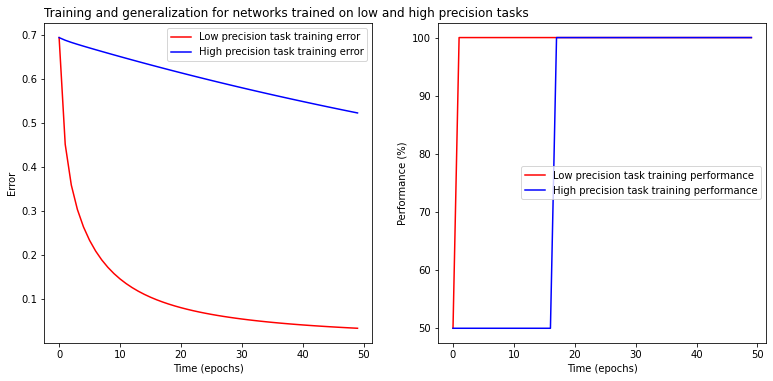

In [97]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net.plot_training_error('red')
net2.plot_training_error('blue')
plt.legend(["Low precision task training error",
            "High precision task training error"]);
plt.title("Training and generalization for networks trained on low and high precision tasks", loc = "left")

plt.subplot(3, 3, 2)
net.plot_training_performance('red')
net2.plot_training_performance('blue')
plt.legend(["Low precision task training performance",
            "High precision task training performance"]);


In [85]:
net3 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis = 3, training_size = 2, alpha = 0.00000007)
optimizer = optim.SGD(net3.parameters(), lr = net3.alpha)
net3.double_train(25, optimizer, np.pi/4, np.pi/100, np.pi/16, 100)

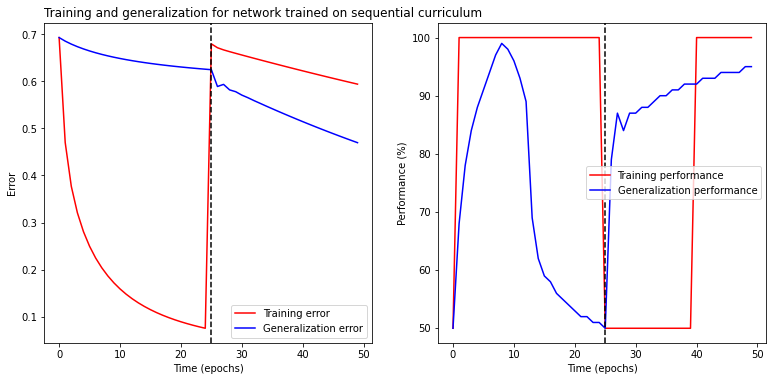

In [78]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net3.plot_training_error('red')
net3.plot_generalization_error("blue")
plt.axvline(25, 0, 1, linestyle = 'dashed', color = 'black');
plt.legend(["Training error", "Generalization error"]);
plt.title("Training and generalization for network trained on sequential curriculum", loc = "left")

plt.subplot(3, 3, 2)
net3.plot_training_performance('red')
net3.plot_generalization_performance("blue")
plt.legend(["Training performance", "Generalization performance"]);
plt.axvline(25, 0, 1, linestyle = 'dashed', color = 'black');


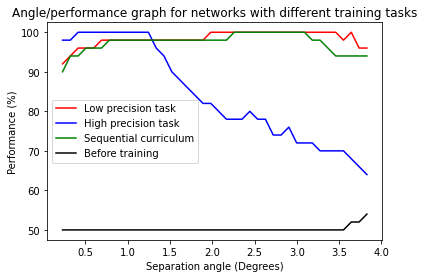

In [86]:
net4 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, phis = 3, training_size = 2, alpha = 0.0001)
net.plot_angle_performance(40, 'red')
net2.plot_angle_performance(40, 'blue')
net3.plot_angle_performance(40, 'green')
net4.plot_angle_performance(40, 'black')
plt.legend(["Low precision task", "High precision task", "Sequential curriculum", "Before training"]);
plt.title("Angle/performance graph for networks with different training tasks", loc = 'center');

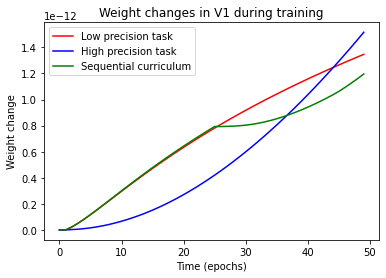

In [80]:
net.plot_weight_change('red', v1 = True)
net2.plot_weight_change('blue', v1 = True)
net3.plot_weight_change('green', v1 = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in V1 during training");

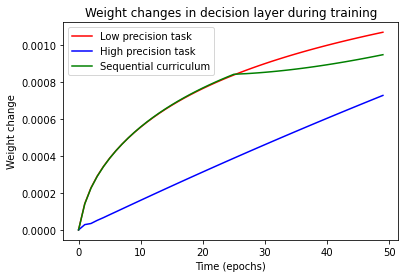

In [81]:
net.plot_weight_change('red', w32 = True)
net2.plot_weight_change('blue', w32 = True)
net3.plot_weight_change('green', w32 = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in decision layer during training");

In [3]:
input = torch.rand(1, 1, 5, 5)
weight = torch.randn(1, 4, 1, 4, 4, 2**2)
input

tensor([[[[0.1902, 0.8093, 0.2169, 0.7991, 0.8802],
          [0.2896, 0.1205, 0.1861, 0.6734, 0.7623],
          [0.7764, 0.7403, 0.0861, 0.1348, 0.8726],
          [0.5286, 0.8812, 0.0371, 0.4929, 0.9494],
          [0.4610, 0.8472, 0.5420, 0.5009, 0.6494]]]])

In [4]:
weight.shape

torch.Size([1, 4, 1, 4, 4, 4])

In [5]:
output = input.unfold(2, 2, 1).unfold(3, 2, 1)
output2 = output.contiguous().view(*output.size()[:-2],-1)
output2.shape

torch.Size([1, 1, 4, 4, 4])

In [38]:
out = (output2.unsqueeze(1) * weight).sum([2,-1])
a = []
for i in range(0, 4, 2):
    a.append(torch.sum(out[0][i:i+2] ** 2, dim = 0))
out, torch.stack(a).view(2, 4, 4)

(tensor([[[[-8.8609e-01,  1.4144e-01,  3.3592e-02,  2.3889e+00],
           [ 6.1357e-01, -2.3320e-03, -9.0398e-01, -6.6459e-02],
           [-1.9733e+00,  5.9907e-01,  6.8793e-01,  2.5147e+00],
           [ 1.1724e+00,  8.3661e-01,  3.2506e-02, -2.4237e-01]],
 
          [[-2.7683e-02,  4.1063e-02,  2.6899e-01,  5.0825e-01],
           [ 1.0065e-01, -3.7913e-01,  1.1162e+00, -1.3634e+00],
           [-1.6172e+00, -2.1688e+00,  5.8416e-01, -5.3280e-01],
           [-1.2030e+00,  2.2461e+00, -7.9992e-01,  1.2372e+00]],
 
          [[-1.2419e+00, -4.5059e-01,  9.7438e-03, -5.9064e-01],
           [-9.5074e-01,  8.0174e-01,  5.6355e-01,  2.4328e+00],
           [ 1.1334e+00, -1.5967e+00, -5.1475e-01,  2.5579e+00],
           [ 7.4123e-01,  1.5458e+00, -1.0115e+00,  4.6402e-01]],
 
          [[ 5.7490e-01, -6.2669e-01,  1.7338e+00, -2.0372e+00],
           [-8.2743e-01, -4.2821e-02, -4.2092e-01,  6.8354e-02],
           [ 1.3654e-01,  1.1119e+00,  6.6431e-01,  1.9692e-02],
           [ 2.0

In [194]:
weight.sum([2,-1])

tensor([[[[ 0.2409,  1.1685],
          [ 0.6973, -0.3850]]]])

In [348]:
def generate_gabor(size, theta):
    ksize = size
    sigma = 3
    lamda = 5
    gamma = 0.5
    phi = 0
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
    return torch.tensor(kernel).view(1, 1, size, size).float()

angles = np.linspace(0, np.pi, 6)
weights = []
for i in range(6):
    for j in range(49):
        theta = angles[i]
        kernel = generate_gabor(5, theta)
        weights.append(kernel)
weight = torch.stack(weights).view(1, 6, 1, 7, 7, 25)
weights

[tensor([[[[-0.6128,  0.2765,  0.9460,  0.2765, -0.6128],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6478,  0.2923,  1.0000,  0.2923, -0.6478],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6128,  0.2765,  0.9460,  0.2765, -0.6128]]]]),
 tensor([[[[-0.6128,  0.2765,  0.9460,  0.2765, -0.6128],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6478,  0.2923,  1.0000,  0.2923, -0.6478],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6128,  0.2765,  0.9460,  0.2765, -0.6128]]]]),
 tensor([[[[-0.6128,  0.2765,  0.9460,  0.2765, -0.6128],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6478,  0.2923,  1.0000,  0.2923, -0.6478],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
           [-0.6128,  0.2765,  0.9460,  0.2765, -0.6128]]]]),
 tensor([[[[-0.6128,  0.2765,  0.9460,  0.2765, -0.6128],
           [-0.6389,  0.2883,  0.9862,  0.2883, -0.6389],
  

In [345]:

inputs = []

x = np.linspace(0, np.pi, 10)

for i in range(1):
    theta = x[i]
    kernel = generate_gabor(11, theta)
    inputs.append(kernel)

input = torch.stack(inputs).view(1, 1, 11, 11)
output = input.unfold(2, 5, 1).unfold(3, 5, 1)
output2 = output.contiguous().view(*output.size()[:-2],-1)
out = (output2.unsqueeze(1) * weight).sum([2,-1])
output2.shape

torch.Size([1, 1, 7, 7, 25])

In [233]:
np.linspace(0, np.pi, 3), np.pi/2

(array([0.        , 1.57079633, 3.14159265]), 1.5707963267948966)

In [74]:
m = nn.MaxPool2d((2,2), stride = (2,2))
input = torch.rand(1, 1, 5, 5)
input, m(input)

(tensor([[[[0.2895, 0.7121, 0.9417, 0.2207, 0.6506],
           [0.6913, 0.7290, 0.3796, 0.9106, 0.9665],
           [0.4800, 0.3665, 0.2166, 0.1707, 0.6151],
           [0.8305, 0.9675, 0.4218, 0.2555, 0.2691],
           [0.5126, 0.7091, 0.1010, 0.7505, 0.5868]]]]),
 tensor([[[[0.7290, 0.9417],
           [0.9675, 0.4218]]]]))

In [305]:
for i in range(0, 10, 2):
    print(i)

0
2
4
6
8


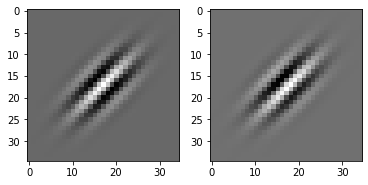

In [230]:
fig, [ax1, ax2] = plt.subplots(1, 2)
ksize = 35
sigma = 3
lamda = 5
gamma = 0.5
phi = 0
theta = np.pi/4
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
ax1.imshow(kernel, 'gray')


ksize = 35
sigma = 3
lamda = 5
gamma = 0.5
phi = np.pi/4
theta = np.pi/4
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
ax2.imshow(kernel, 'gray')

In [16]:
a = torch.rand(2, 2)

In [22]:
a, a**2

(tensor([[0.4833, 0.3313],
         [0.6700, 0.6815]]),
 tensor([[0.2336, 0.1098],
         [0.4489, 0.4644]]))

In [ ]:
class LCN(nn.Module):
    
    def __init__(self, input_size, simple_number, simple_size, phis, training_size, alpha = 0.0001):
        super(LCN, self).__init__()
        self.input_size = input_size
        self.simple_number = simple_number
        self.simple_size = simple_size
        self.phis = phis
        self.training_size = training_size
        self.alpha = alpha
        self.dimensions = self.input_size - self.simple_size + 1
        
        
        self.simple_weight = torch.nn.Parameter(self.init_weights())
        

        
        self.decision = nn.Linear(self.dimensions*self.dimensions*self.simple_number, 2)
        self.decision.weight = torch.nn.Parameter(
            torch.zeros((2, self.dimensions*self.dimensions*self.simple_number)))
        
        
    def init_weights(self):
        angles = self.remove_ambiguous_stimuli(0, np.pi, self.simple_number)
        phis = np.linspace(0, np.pi, self.phis)
        weights = []
        for i in range(self.simple_number):
            for j in range(self.phis):
                for k in range(self.dimensions ** 2):
                    theta = angles[i]
                    phi = phis[j]
                    kernel = self.generate_gabor(self.simple_size, theta, phi)
                    weights.append(kernel)
                
        weight = torch.stack(weights).view(
            1, self.simple_number*self.phis, 1, self.dimensions, self.dimensions, self.simple_size ** 2)
        return weight
    
    def generate_gabor(self, size, theta, phi):
        ksize = size
        sigma = 3
        lamda = 5
        gamma = 0.5
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        return torch.tensor(kernel).view(1, 1, size, size).float()
    
    def remove_ambiguous_stimuli(self, angle1, angle2, size):
        x = np.linspace(angle1, angle2, size)
        stimuli = [-np.pi/2, 0, np.pi/2, np.pi]
        ambiguous = True
        while ambiguous == True:
            for i in stimuli:
                x = np.where(x == i, i+0.1, x)
            x = np.linspace(x[0], x[-1], size)
            if -np.pi/2 in x or 0 in x or np.pi/2 in x:
                ambiguous = True
            else:
                ambiguous = False
        return x
    
    def binary_loss(self, scores, desired_output):
        loss = nn.CrossEntropyLoss()
        return loss(scores, desired_output)
    
    def inputting(self, angle1, angle2):
        
        self.labels = []
        self.inputs = []
    
        x = self.remove_ambiguous_stimuli(angle1, angle2, self.training_size)

        for i in range(self.training_size):
            theta = x[i]
            kernel = self.generate_gabor(self.input_size, theta, phi = 0)
            self.inputs.append(kernel)
            if 0 < theta < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            self.labels.append(label)
        self.input = torch.stack(self.inputs).view(self.training_size, 1, self.input_size, self.input_size)
        return self.input
    
    def desired_outputting(self):
        self.desired_output = torch.tensor(self.labels)
        return self.desired_output
    
    def forward(self, x):
        x = x.unfold(2, self.simple_size, 1).unfold(3, self.simple_size, 1)
        x = x.contiguous().view(*x.size()[:-2], -1)
        out = (x.unsqueeze(1) * self.simple_weight).sum([2, -1])
        pools = []
        for i in range(0, self.simple_number*self.phis, self.phis):
            pool = torch.mean(out[0][i:i+self.phis], dim = 0).view(1, self.dimensions, self.dimensions)
            pools.append(pool)
        pools = torch.stack(pools).view(self.simple_number, self.dimensions, self.dimensions)
        out = pools.view(1, self.dimensions*self.dimensions*self.simple_number)
        out = self.decision(out)
        return out
    
    def mean_train(self, iterations, optimizer):
        self.before_v1weight = self.simple_weight.clone()
        self.before_w32weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []

        for i in range(iterations):
            optimizer.zero_grad()
            self.training_score = 0
            loss2 = []
            
            for j in range(self.training_size):
                
                self.scores = self.forward(self.input[j][0].view(1, 1, self.input_size, self.input_size))
                loss1 = self.binary_loss(self.scores, self.desired_output[j].view(1))
                if torch.argmax(self.scores) == self.desired_output[j]:
                    self.training_score += 1
                loss2.append(loss1)
                
            loss = np.sum(loss2)/self.training_size
            self.losses.append(loss)
            
            self.training_score = self.training_score/self.training_size * 100
            self.training_scores.append(self.training_score)
            
            self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
            self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.decision.weight))
            
            loss.backward()
            optimizer.step()
            
    def double_train(self, iterations, optimizer, angle1, angle2, test_angle, test_size):        
        self.before_v1weight = self.simple_weight.clone()
        self.before_w32weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []
        self.generalize_error = []
        self.generalize_perform = []
        for angle in [angle1, angle2]:
            input = self.inputting(-angle, angle)
            desired_output = self.desired_outputting()
            for i in range(iterations):
                self.training_score = 0
                loss2 = []

                for j in range(self.training_size):
                    optimizer.zero_grad()
                    self.scores = self.forward(input[j][0].view(1, 1, self.input_size, self.input_size))
                    loss1 = self.binary_loss(self.scores, desired_output[j].view([1]))
                    if torch.argmax(self.scores) == desired_output[j]:
                        self.training_score += 1
                    loss2.append(loss1)

                loss = np.sum(loss2)/self.training_size
                self.losses.append(loss)

                self.training_score = self.training_score/self.training_size * 100
                self.training_scores.append(self.training_score)

                generalize = self.generalization(test_angle, test_size)
                self.generalize_error.append(self.general_mean_error)
                self.generalize_perform.append(self.generalization_score)

                self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
                self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.decision.weight))

                loss.backward()
                optimizer.step()
    
    def plot_training_error(self, color):
        plt.plot(self.losses, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")

    def plot_training_performance(self, color):
        plt.plot(self.training_scores, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")
        
    def generalization(self, angle, test_size):
        angles = self.remove_ambiguous_stimuli(-angle, angle, test_size)
        self.generalization_score = 0
        general_error = []
        for i in range(test_size):
            gabor = net.generate_gabor(self.input_size, angles[i], phi = 0).clone().detach()
            if 0 < angles[i] < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            with torch.no_grad():
                a = self.forward(gabor)
                if torch.argmax(a) == label:
                    self.generalization_score += 1
                general_error.append(self.binary_loss(a, label))
        self.generalization_score = self.generalization_score/test_size * 100
        self.general_mean_error = np.mean(general_error)

    def plot_generalization_performance(self, color):
        plt.plot(self.generalize_perform, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")

    def plot_generalization_error(self, color):
        plt.plot(self.generalize_error, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")
   
    def plot_angle_performance(self, number, color):
        angles = self.remove_ambiguous_stimuli(0, np.pi/2, number)
        scores = []
        for i in range(number):
            self.generalization(angles[i], 50)
            scores.append(self.generalization_score)
        plt.plot((360 * angles)/(50 * np.pi), scores, color = color)
        plt.xlabel("Separation angle (Degrees)")
        plt.ylabel("Performance (%)")

    def v1_weight_change(self, before, after):
        diff = after - before
        net_diff = []
        for i in diff.view(self.simple_number*self.phis, 1, self.dimensions, self.dimensions, self.simple_size ** 2):
            for j in i.view(self.dimensions, self.dimensions, self.simple_size ** 2):
                for k in j:
                    net_diff.append(torch.linalg.norm(k.view(self.simple_size, self.simple_size), ord = 'fro').item())
        return np.mean(net_diff)
    
    def w32_weight_change(self, before, after):
        diff = after - before
        net_diff = (torch.linalg.norm(
            diff.view(2, self.dimensions*self.dimensions*self.simple_number), ord = 'fro').item())
        return net_diff
    
    def plot_weight_change(self, color, v1 = False, w32 = False):
        if v1 == True:
            plt.plot(self.before_v1weights, color = color)
        if w32 == True:
            plt.plot(self.before_w32weights, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Weight change")